<a href="https://colab.research.google.com/github/simulate111/Computer-Vision-and-Sensor-Fusion/blob/main/Assignment4_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Assignment 4: TKO_7096-3001 Computer Vision and Sensor Fusion


Goal: develop a RGB-Depth fusion architecture for semantic segmentation based on Fully Convolutional Network (FCN) .


<font color='red'> Deadline: 25.03.2024 at 24:00.

- Imports go here

In [1]:
!pip -q install requests beautifulsoup4
!pip -q install selenium
!apt-get update
!apt -q install chromium-chromedriver

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.9/492.9 kB 21.0 MB/s eta 0:00:00
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,673 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,682 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,745 kB]
Get:12 http://

In [4]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 582.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 92.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.5 MB/s eta 0:00:00


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from google.colab import files
import zipfile

### Load the dataset and Ground-truth###

- Dataset consists of 1100 (per modality) images of road scenes. It is divided into train (600 images), test (200 images) and validation (300 images) datasets.
- Change the size of all images into 256*256.
- Converting the labels into one hot encoding
- Create a DataLoader for loading the files when training the model.

In [6]:

# Upload the dataset from your local computer
uploaded = files.upload()

# Extract the dataset if it's in a zip file
for filename in uploaded.keys():
    if filename.endswith('.zip'):
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall("/content/dataset")  # Change the path as needed
        print(f"Dataset extracted to /content/dataset")


Saving dataset.zip to dataset.zip
Dataset extracted to /content/dataset


In [7]:
"""
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import requests
import zipfile
import os
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

def download_and_extract_zip_selenium(url, extract_path="/content/dataset"):
    #Downloads and extracts a zip file from a SharePoint URL using Selenium.

    chrome_options = Options()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')

    driver = webdriver.Chrome(options=chrome_options)
    driver.get(url)

    # 1. Inspect and Print Page Source (for debugging)
    print(driver.page_source)  # Print the HTML to examine the structure

    # 2. Find the Download Button (replace with your actual selector)
    try:
        wait = WebDriverWait(driver, 10)
        # Example: Using CSS Selector (adjust as needed)
        download_button = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "button[data-automationid='downloadButton']")))  # Example selector
        download_link = download_button.get_attribute('href')

        # (Optional) Take a screenshot after finding the element
        driver.save_screenshot("download_button_found.png")

    except Exception as e:
        print(f"Error finding download link: {e}")
        driver.save_screenshot("download_button_error.png")  # Take a screenshot if an error occurs
        driver.quit()
        return

    driver.quit()

    # 3. Download and Extract
    zip_filename = os.path.join(extract_path, "dataset.zip")
    response = requests.get(download_link, stream=True)
    with open(zip_filename, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Dataset extracted to {extract_path}")

# Example usage
url = "https://utufi-my.sharepoint.com/:u:/g/personal/moakht_utu_fi/EbBVU01QQ8ZInxQy52BEB58BqmAdE6age2qvZi44hOOMCQ?e=mUGRyn"
download_and_extract_zip_selenium(url)
"""

'\nfrom selenium import webdriver\nfrom selenium.webdriver.chrome.options import Options\nimport requests\nimport zipfile\nimport os\nfrom selenium.webdriver.support.ui import WebDriverWait\nfrom selenium.webdriver.support import expected_conditions as EC\nfrom selenium.webdriver.common.by import By\n\ndef download_and_extract_zip_selenium(url, extract_path="/content/dataset"):\n    #Downloads and extracts a zip file from a SharePoint URL using Selenium.\n\n    chrome_options = Options()\n    chrome_options.add_argument(\'--headless\')\n    chrome_options.add_argument(\'--no-sandbox\')\n    chrome_options.add_argument(\'--disable-dev-shm-usage\')\n\n    driver = webdriver.Chrome(options=chrome_options)\n    driver.get(url)\n\n    # 1. Inspect and Print Page Source (for debugging)\n    print(driver.page_source)  # Print the HTML to examine the structure\n\n    # 2. Find the Download Button (replace with your actual selector)\n    try:\n        wait = WebDriverWait(driver, 10)\n        #

In [8]:
# Verify extraction
extracted_files = os.listdir("/content/dataset")
print("Extracted files:", extracted_files)

Extracted files: ['dataset']


In [9]:
import glob
import os

# Base dataset directory (adjusted for nested structure)
base_dir = '/content/dataset/dataset'

# Function to get .npy file paths for a specific split (train/test/validation) and modality (rgb/depth/label)
def get_npy_paths(split, modality):
    return sorted(glob.glob(os.path.join(base_dir, split, modality, '*.npy')))

# Load paths for training, validation, and testing datasets
rgb_train_paths = get_npy_paths('train', 'rgb')
depth_train_paths = get_npy_paths('train', 'depth')
label_train_paths = get_npy_paths('train', 'label')

rgb_val_paths = get_npy_paths('validation', 'rgb')
depth_val_paths = get_npy_paths('validation', 'depth')
label_val_paths = get_npy_paths('validation', 'label')

rgb_test_paths = get_npy_paths('test', 'rgb')
depth_test_paths = get_npy_paths('test', 'depth')
label_test_paths = get_npy_paths('test', 'label')

# Quick check to confirm paths are loaded
print(f"Train RGB: {len(rgb_train_paths)}, Depth: {len(depth_train_paths)}, Labels: {len(label_train_paths)}")
print(f"Validation RGB: {len(rgb_val_paths)}, Depth: {len(depth_val_paths)}, Labels: {len(label_val_paths)}")
print(f"Test RGB: {len(rgb_test_paths)}, Depth: {len(depth_test_paths)}, Labels: {len(label_test_paths)}")

Train RGB: 600, Depth: 600, Labels: 600
Validation RGB: 100, Depth: 100, Labels: 100
Test RGB: 200, Depth: 200, Labels: 200


In [12]:
!pip -q install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 19.5 MB/s eta 0:00:00


In [13]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
import numpy as np
import cv2

class DataLoader(Sequence):
    """
    Data loader for RGB, depth, and label images.

    Args:
        rgb_paths (list): List of paths to RGB images.
        depth_paths (list): List of paths to depth images.
        label_paths (list): List of paths to label images.
        batch_size (int): Batch size.
        num_classes (int, optional): Number of classes. Defaults to 19.
        target_size (tuple, optional): Target image size. Defaults to (256, 256).
        normalize (bool, optional): Whether to normalize RGB and depth images. Defaults to True.
    """
    def __init__(self, rgb_paths, depth_paths, label_paths, batch_size, num_classes=19, target_size=(256, 256), normalize=True):
        self.rgb_paths = rgb_paths
        self.depth_paths = depth_paths
        self.label_paths = label_paths
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.target_size = target_size
        self.normalize = normalize

    def __len__(self):
        """Returns the number of batches in the dataset."""
        return int(np.floor(len(self.rgb_paths) / self.batch_size))

    def __getitem__(self, idx):
        """Retrieves a batch of data at the specified index."""
        batch_rgb = self.rgb_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_depth = self.depth_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.label_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        return self.__generate_data(batch_rgb, batch_depth, batch_labels)

    def __generate_data(self, batch_rgb_files, batch_depth_files, batch_label_files):
        """Loads and preprocesses the RGB images, depth images, and labels."""
        try:
            rgb_images = np.array([cv2.resize(np.load(file), self.target_size) for file in batch_rgb_files])
            depth_images = np.array([cv2.resize(np.concatenate([np.load(file), np.load(file), np.load(file)], axis=-1), self.target_size) for file in batch_depth_files])
            if self.normalize:
                rgb_images = rgb_images / 255.0
                depth_images = depth_images / 255.0  # Normalize depth images as well
            labels = np.array([cv2.resize(to_categorical(np.load(file), num_classes=self.num_classes), self.target_size) for file in batch_label_files])
            labels = labels.reshape(labels.shape[0], -1, labels.shape[-1])
            return (rgb_images, depth_images), labels
        except Exception as e:
            print(f"Error generating data: {e}")
            return None, None  # Or handle the error in a more appropriate way

In [14]:
batch_size = 3  # Or any other appropriate value
data_loader = DataLoader(rgb_train_paths, depth_train_paths, label_train_paths, batch_size, normalize=False)

- Visualize the data you have prepared

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_samples(rgb_images, depth_images, labels):
    """Visualizes RGB images, depth images, and labels."""

    num_samples = len(rgb_images)
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        axes[i, 0].imshow(rgb_images[i])
        axes[i, 0].set_title("RGB Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(depth_images[i], cmap='viridis')
        axes[i, 1].set_title("Depth Image")
        axes[i, 1].axis("off")

        # Print the shape of the labels array for debugging
        print("Shape of labels array:", labels[i].shape)

        # Reshape the labels before displaying (correct dimensions)
        try:
            reshaped_labels = labels[i].reshape(256, 256, 19).argmax(axis=-1) #Added Argmax to get the class index.
            axes[i, 2].imshow(reshaped_labels)
            axes[i, 2].set_title("Labels")
            axes[i, 2].axis("off")
        except ValueError as e:
            print(f"Error reshaping labels: {e}. Skipping label display.")
            axes[i, 2].text(0.5, 0.5, "Label Reshape Error", ha="center", va="center", color="red")
            axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

In [16]:
print(np.load(rgb_train_paths[0]).shape)
print(np.load(depth_train_paths[0]).shape)
print(np.load(label_train_paths[0]).shape)


(128, 256, 3)
(128, 256, 1)
(128, 256)


In [17]:
import numpy as np

# Assuming rgb_train_paths, depth_train_paths, and label_train_paths are already defined

depth_train_data = [np.load(path) for path in depth_train_paths]
rgb_train_data = [np.load(path) for path in rgb_train_paths]
label_train_data = [np.load(path) for path in label_train_paths]

# Modify the depth data
modified_depth_data = []
for depth_img in depth_train_data:
    modified_depth_data.append(np.concatenate([depth_img, depth_img, depth_img], axis=-1))

# Modify the RGB Data (optional, but requested by the prompt)
modified_rgb_data = []
for rgb_img in rgb_train_data:
    modified_rgb_data.append(rgb_img) #no change needed, but the prompt says to copy it.

#Verify the result
print(modified_depth_data[0].shape)
print(modified_rgb_data[0].shape)
print(label_train_data[0].shape)

# Example usage with a visualization function (if you have one):
# visualize_samples(modified_rgb_data, modified_depth_data, label_train_data)

(128, 256, 3)
(128, 256, 3)
(128, 256)


Shape of labels array: (65536, 19)
Shape of labels array: (65536, 19)
Shape of labels array: (65536, 19)


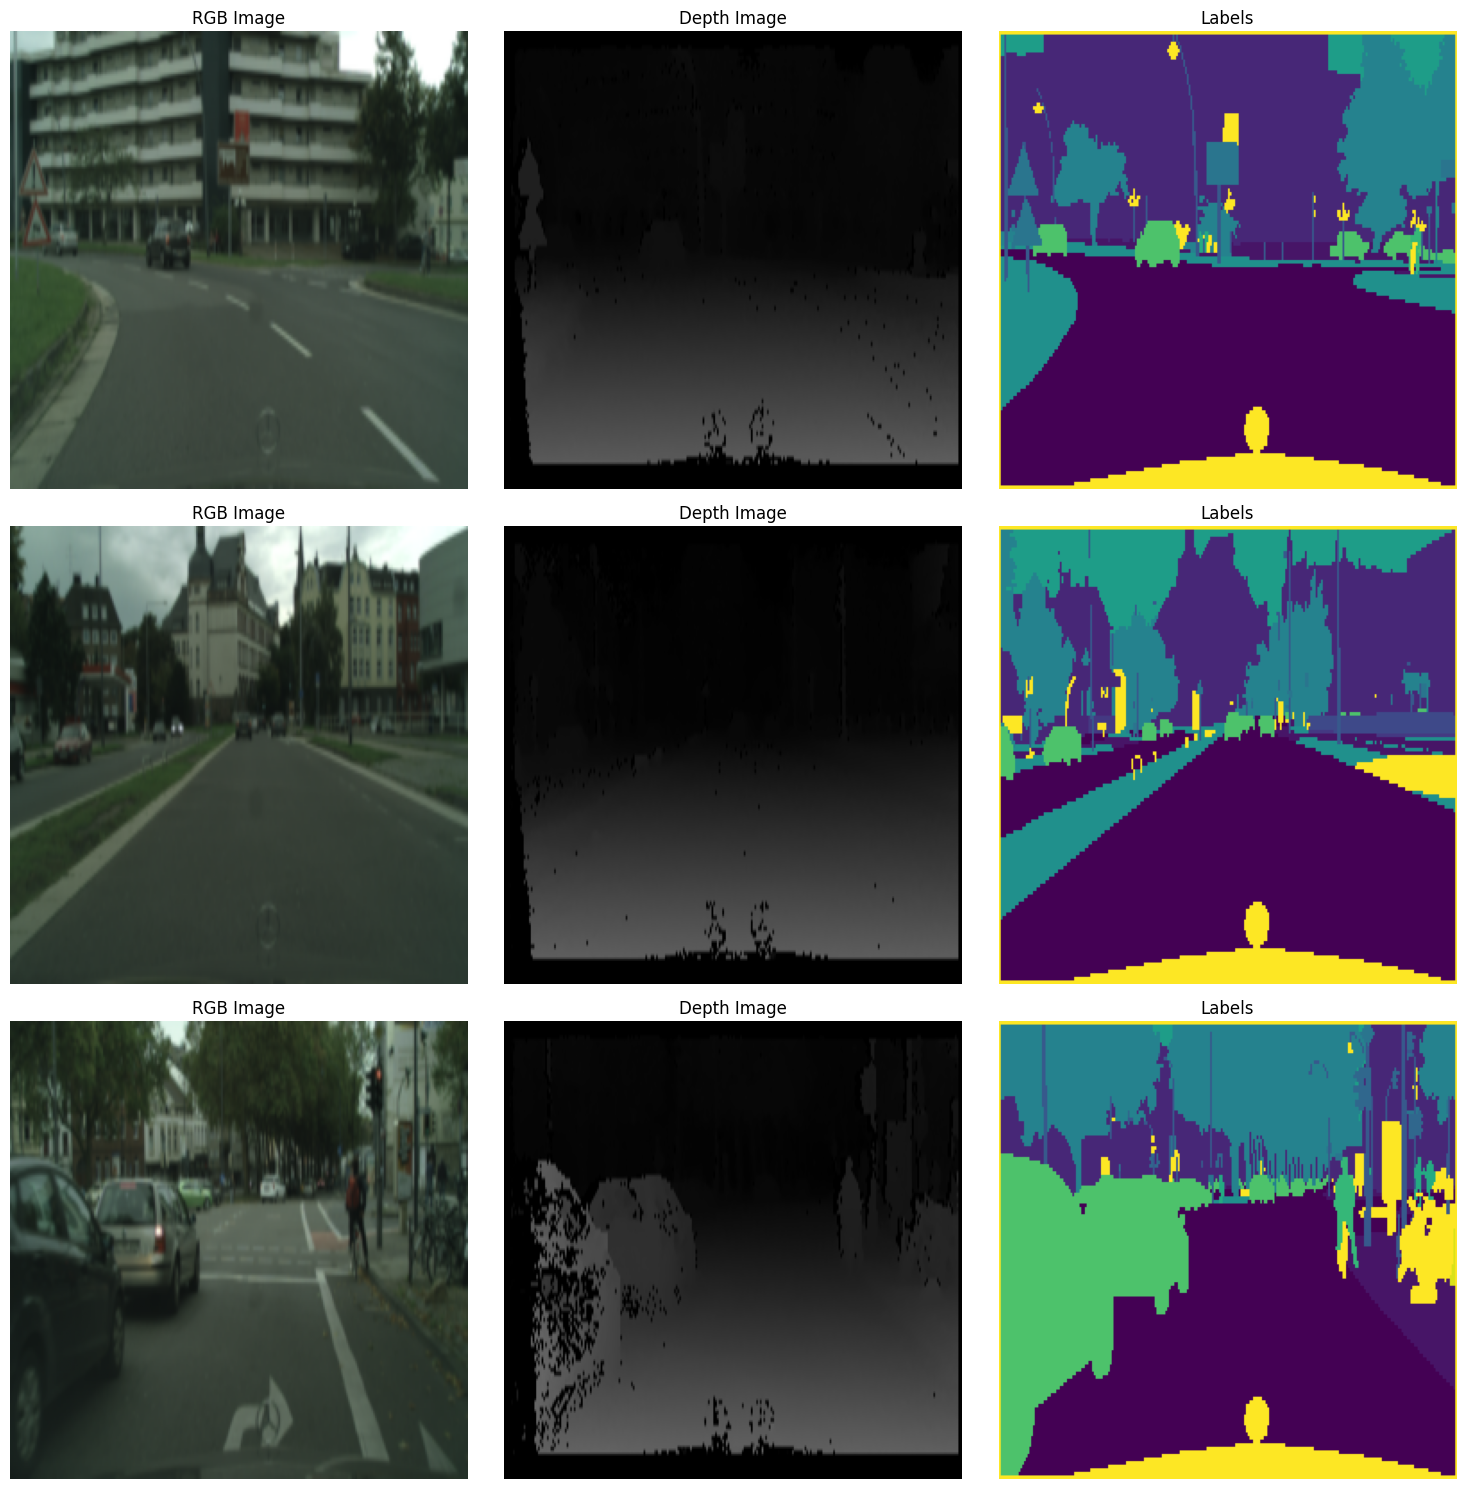

In [18]:
# Get the first batch
(data_rgb, data_depth), data_labels = data_loader[0]

# Visualize the first batch
visualize_samples(data_rgb, data_depth, data_labels)

 Define a Fully Convolutional Network (FCN) for image segmentaion by fusing RGB and depth images. The network consists of  two sterams which each stream has following layers:

    1. Use the pretrained ResNet50 on imageNet
    2. Add two Conv layers with 128 and 256 nodes, respectively. Kernel size (3,3), stride (1,1)
    3. Top of the Conv layers, add dropout layer with 0.2
    4. Concatenate two streams.
    5. Add a transposed convolution layer (Conv2DTranspose)  with Kernel size (64,64), stride (32,32)
    6. Add a softmax activation layer
    
 You can find the model summary and structure in the PDF file.


In [19]:
class UniqueResNet50(layers.Layer):
    def __init__(self, **kwargs):
        super(UniqueResNet50, self).__init__(**kwargs)
        self.resnet = ResNet50(weights='imagenet', include_top=False)
        for layer in self.resnet.layers:
            layer.trainable = False

    def call(self, inputs):
        return self.resnet(inputs)

def build_fcn_segmentation_model(input_shape=(256, 256, 3), num_classes=19):
    """Builds a Fully Convolutional Network (FCN) for image segmentation."""

    # Input layers
    input_rgb = layers.Input(shape=input_shape, name="input_rgb")
    input_depth = layers.Input(shape=input_shape, name="input_depth")

    # ResNet50 base models (pretrained) with unique instances
    rgb_stream = UniqueResNet50()(input_rgb)
    depth_stream = UniqueResNet50()(input_depth)

    # RGB stream
    rgb_stream = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(rgb_stream)
    rgb_stream = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(rgb_stream)
    rgb_stream = layers.Dropout(0.2)(rgb_stream)

    # Depth stream
    depth_stream = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(depth_stream)
    depth_stream = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(depth_stream)
    depth_stream = layers.Dropout(0.2)(depth_stream)

    # Concatenate streams
    concatenated = layers.Concatenate()([rgb_stream, depth_stream])

    # Transposed convolution (upsampling)
    upsampled = layers.Conv2DTranspose(num_classes, (64, 64), strides=(32, 32), padding='same')(concatenated)

    # Reshape (optional, for compatibility with some loss functions)
    reshaped = layers.Reshape((-1, num_classes))(upsampled)

    # Softmax activation
    output = layers.Activation('softmax')(reshaped)

    # Create the model
    model = Model(inputs=[input_rgb, input_depth], outputs=output)
    return model

In [20]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model #The import.

input_layer = layers.Input(shape=(10,))
hidden_layer = layers.Dense(5, activation='relu')(input_layer)
output_layer = layers.Dense(1, activation='sigmoid')(hidden_layer)

model = Model(inputs=input_layer, outputs=output_layer) #Model is used.

In [21]:
# Build the model
model = build_fcn_segmentation_model()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
from tensorflow.keras.callbacks import TensorBoard
import datetime

In [23]:
# TensorBoard setup  (Correct placement)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [24]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_rgb (InputLayer)    │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_depth (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unique_res_net50          │ (None, 8, 8, 2048)     │     23,587,712 │ input_rgb[0][0]        │
│ (UniqueResNet50)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unique_res_net50_1        │ (None, 8, 8, 2048)     │     23,587,712 │ input_depth[0][0]      │
│ (UniqueResNet50)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 8, 8, 128)      │      2,359,424 │ unique_res_net50[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 8, 8, 128)      │      2,359,424 │ unique_res_net50_1[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 8, 8, 256)      │        295,168 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 8, 8, 256)      │        295,168 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 8, 8, 256)      │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 8, 8, 256)      │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 8, 8, 512)      │              0 │ dropout[0][0],         │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 256, 256, 19)   │     39,845,907 │ concatenate[0][0]      │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 65536, 19)      │              0 │ conv2d_transpose[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 65536, 19)      │              0 │ reshape[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 92,330,515 (352.21 MB)

 Trainable params: 45,155,091 (172.25 MB)

 Non-trainable params: 47,175,424 (179.96 MB)

In [25]:
from tensorflow.keras.utils import plot_model

# Assuming 'model' is your Keras model object
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


Compile the model with SGD(learning_rate=0.01, decay=1e-5, momentum=0.9) and loss="categorical_crossentropy"

Train the model on the “train” dataset  and “validation”dataset for epochs =10.

In [31]:
# Compile the model
optimizer = optimizers.SGD(learning_rate=0.008, decay=1e-6, momentum=0.9)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy'])


In [32]:
# Create data loaders
batch_size = 16
train_loader = DataLoader(rgb_train_paths, depth_train_paths, label_train_paths, batch_size)
val_loader = DataLoader(rgb_val_paths, depth_val_paths, label_val_paths, batch_size)


In [33]:
# Generator function to iterate through DataLoader
def generator(data_loader):
  for idx in range(len(data_loader)):
    yield data_loader.__getitem__(idx)

In [34]:
# Convert the DataLoaders to TensorFlow Datasets with explicit types and shapes
train_dataset = tf.data.Dataset.from_generator(
    lambda: generator(train_loader), # Use the generator function
    output_types=((tf.float32, tf.float32), tf.float32),
    output_shapes=(((batch_size, 256, 256, 3), (batch_size, 256, 256, 3)), (batch_size, 65536, 19))
)
val_dataset = tf.data.Dataset.from_generator(
    lambda: generator(val_loader), # Use the generator function
    output_types=((tf.float32, tf.float32), tf.float32),
    output_shapes=(((batch_size, 256, 256, 3), (batch_size, 256, 256, 3)), (batch_size, 65536, 19))
)

In [ ]:
epochs = 10
steps_per_epoch = len(train_loader) #Number of batches in train loader
validation_steps = len(val_loader) #Number of batches in val loader.

model.fit(train_dataset,
          validation_data=val_dataset,
          epochs=epochs,
          steps_per_epoch = steps_per_epoch,
          validation_steps = validation_steps,
          callbacks=[tensorboard_callback])

Epoch 1/10


 Evaluate the model on the training and test dataset. The results must be shown as

- Print loss and accuracy of model for  test dataset.

- Predict semantically segmented images on 5 random example of test dataset.

- Visualize the 5 random examples alongside the ground truth and prediction.

In [ ]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(val_dataset)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

In [ ]:
# Predict semantically segmented images on 5 random examples of the test dataset
num_samples = 5
random_indices = random.sample(range(len(rgb_val_paths)), num_samples)

In [ ]:
for i in random_indices:
    rgb_image = np.load(rgb_val_paths[i]) / 255.0
    depth_image = np.concatenate([np.load(depth_val_paths[i]), np.load(depth_val_paths[i]), np.load(depth_val_paths[i])], axis=-1) / np.max(np.load(depth_val_paths[i])) if np.max(np.load(depth_val_paths[i])) != 0 else np.concatenate([np.load(depth_val_paths[i]), np.load(depth_val_paths[i]), np.load(depth_val_paths[i])], axis=-1)
    ground_truth = np.load(label_val_paths[i])

    # Resize images to match model input shape
    rgb_image = cv2.resize(rgb_image, (256, 256))
    depth_image = cv2.resize(depth_image, (256, 256))

    # Make prediction
    prediction = model.predict([np.expand_dims(rgb_image, axis=0), np.expand_dims(depth_image, axis=0)])
    predicted_labels = np.argmax(prediction, axis=2).reshape((256, 256))

    # Visualize the results
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(rgb_image)
    plt.title("RGB Image")
    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth)
    plt.title("Ground Truth")
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_labels)
    plt.title("Predicted Labels")
    plt.show()

### Extra 5 points :

Implement FCNs for each sing modality and compare their accuracy with fusion model. I need the result of the following table in the same notebook.

# RESULT

| **Modality** | **Test Accuracy(%)** |
| -------- | -------- |
| RGB only |  |
| Depth Only |  |
| RBB and Depth Fusion |  |

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Model, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import Sequence, to_categorical
import numpy as np

# Assuming rgb_train_paths, depth_train_paths, label_train_paths,
# rgb_val_paths, depth_val_paths, label_val_paths are already defined

class UniqueResNet50(layers.Layer):
    def __init__(self, **kwargs):
        super(UniqueResNet50, self).__init__(**kwargs)
        self.resnet = ResNet50(weights='imagenet', include_top=False)
        for layer in self.resnet.layers:
            layer.trainable = False

    def call(self, inputs):
        return self.resnet(inputs)

def build_fcn_segmentation_model(input_shape=(256, 256, 3), num_classes=19):
    """Builds a Fully Convolutional Network (FCN) for image segmentation."""

    # Input layers
    input_rgb = layers.Input(shape=input_shape, name="input_rgb")
    input_depth = layers.Input(shape=input_shape, name="input_depth")

    # ResNet50 base models (pretrained) with unique instances
    rgb_stream = UniqueResNet50()(input_rgb)
    depth_stream = UniqueResNet50()(input_depth)

    # RGB stream
    rgb_stream = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(rgb_stream)
    rgb_stream = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(rgb_stream)
    rgb_stream = layers.Dropout(0.2)(rgb_stream)

    # Depth stream
    depth_stream = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(depth_stream)
    depth_stream = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(depth_stream)
    depth_stream = layers.Dropout(0.2)(depth_stream)

    # Concatenate streams
    concatenated = layers.Concatenate()([rgb_stream, depth_stream])

    # Transposed convolution (upsampling)
    upsampled = layers.Conv2DTranspose(num_classes, (64, 64), strides=(32, 32), padding='same')(concatenated)

    # Reshape (optional, for compatibility with some loss functions)
    reshaped = layers.Reshape((-1, num_classes))(upsampled)

    # Softmax activation
    output = layers.Activation('softmax')(reshaped)

    # Create the model
    model = Model(inputs=[input_rgb, input_depth], outputs=output)
    return model

class DataLoader(Sequence):
    def __init__(self, rgb_paths, depth_paths, label_paths, batch_size, num_classes=19):
        self.rgb_paths = rgb_paths
        self.depth_paths = depth_paths
        self.label_paths = label_paths
        self.batch_size = batch_size
        self.num_classes = num_classes

    def __len__(self):
        return int(np.ceil(len(self.rgb_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_rgb = self.rgb_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_depth = self.depth_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.label_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        return self.__generate_data(batch_rgb, batch_depth, batch_labels)

    def __generate_data(self, batch_rgb_files, batch_depth_files, batch_label_files):
        rgb_images = np.array([np.load(file) / 255.0 for file in batch_rgb_files])  # Normalize RGB
        depth_images = np.array([np.concatenate([np.load(file), np.load(file), np.load(file)], axis=-1) / np.max(np.load(file)) if np.max(np.load(file)) != 0 else np.concatenate([np.load(file), np.load(file), np.load(file)], axis=-1) for file in batch_depth_files])  # Normalize depth and duplicate channel
        labels = np.array([to_categorical(np.load(file), num_classes=self.num_classes) for file in batch_label_files])
        return [rgb_images, depth_images], labels

# Build the model
model = build_fcn_segmentation_model()

# Compile the model
optimizer = optimizers.SGD(learning_rate=0.01, decay=1e-5, momentum=0.9)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy'])

# Create data loaders
batch_size = 16 #adjust as needed.
train_loader = DataLoader(rgb_train_paths, depth_train_paths, label_train_paths, batch_size)
val_loader = DataLoader(rgb_val_paths, depth_val_paths, label_val_paths, batch_size)

# Train the model
epochs = 10
model.fit(train_loader, validation_data=val_loader, epochs=epochs)